# SECTION 1: DECLARE THE MODULES

In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# SECTION 2: Data import and preprocess
#Run this but dont worry if it does not make any sense Jump to SECTION 3 that is related to your HD task.

In [2]:
DataSet = "Week_5_NSL-KDD-Dataset/training_attack_types.txt"
DataSet

'Week_5_NSL-KDD-Dataset/training_attack_types.txt'

In [3]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate','rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx)) #doesn't contain numbers in above 2 variables

nominal_cols = col_names[nominal_idx].tolist() #gives col names in header names according to number held in idx var
binary_cols = col_names[binary_idx].tolist()   #basically differentating according to type
numeric_cols = col_names[numeric_idx].tolist()

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

In [4]:
#Processing Training Data
train_file = "Week_5_NSL-KDD-Dataset/KDDTrain+.txt"

train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'].map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

In [5]:
#Processing test Data
test_file = "Week_5_NSL-KDD-Dataset/KDDTest+.txt"

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'].map(lambda x: attack_mapping[x]) #adds column with type defined in mapping
test_df.drop(['success_pred'], axis=1, inplace=True)

<AxesSubplot:>

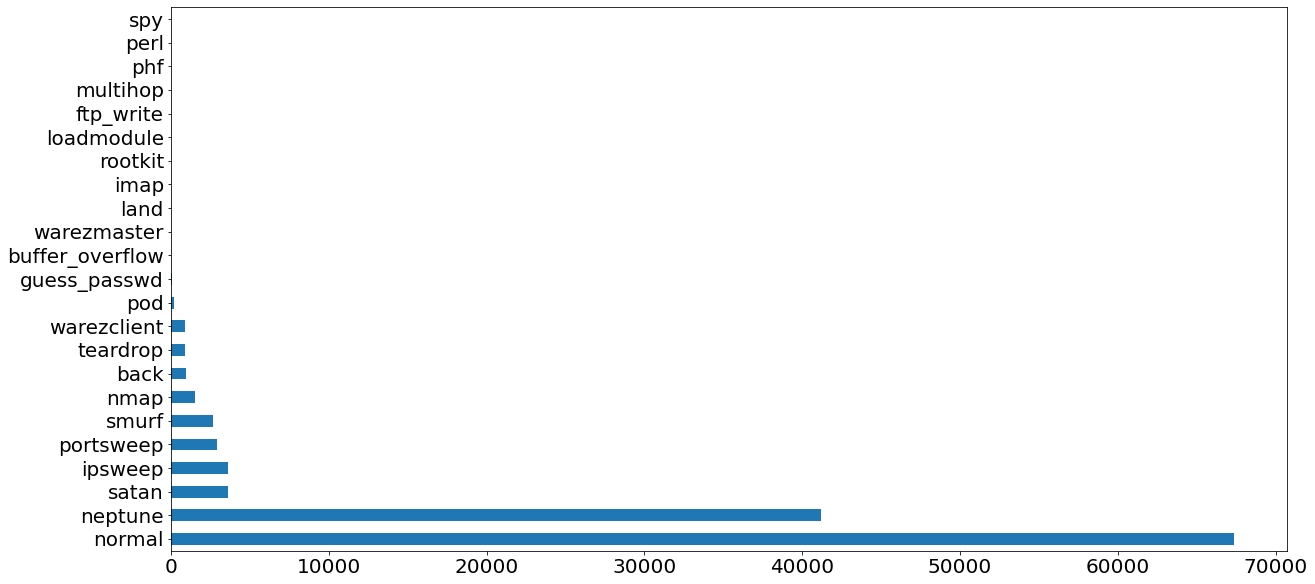

In [6]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

<AxesSubplot:>

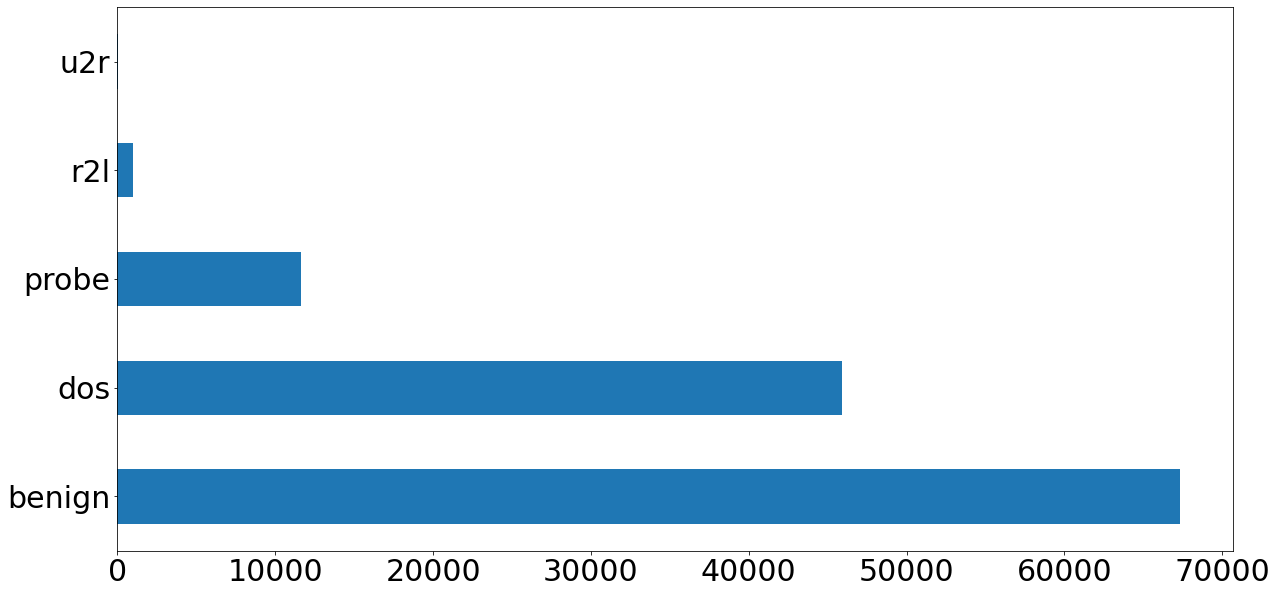

In [7]:
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

<AxesSubplot:>

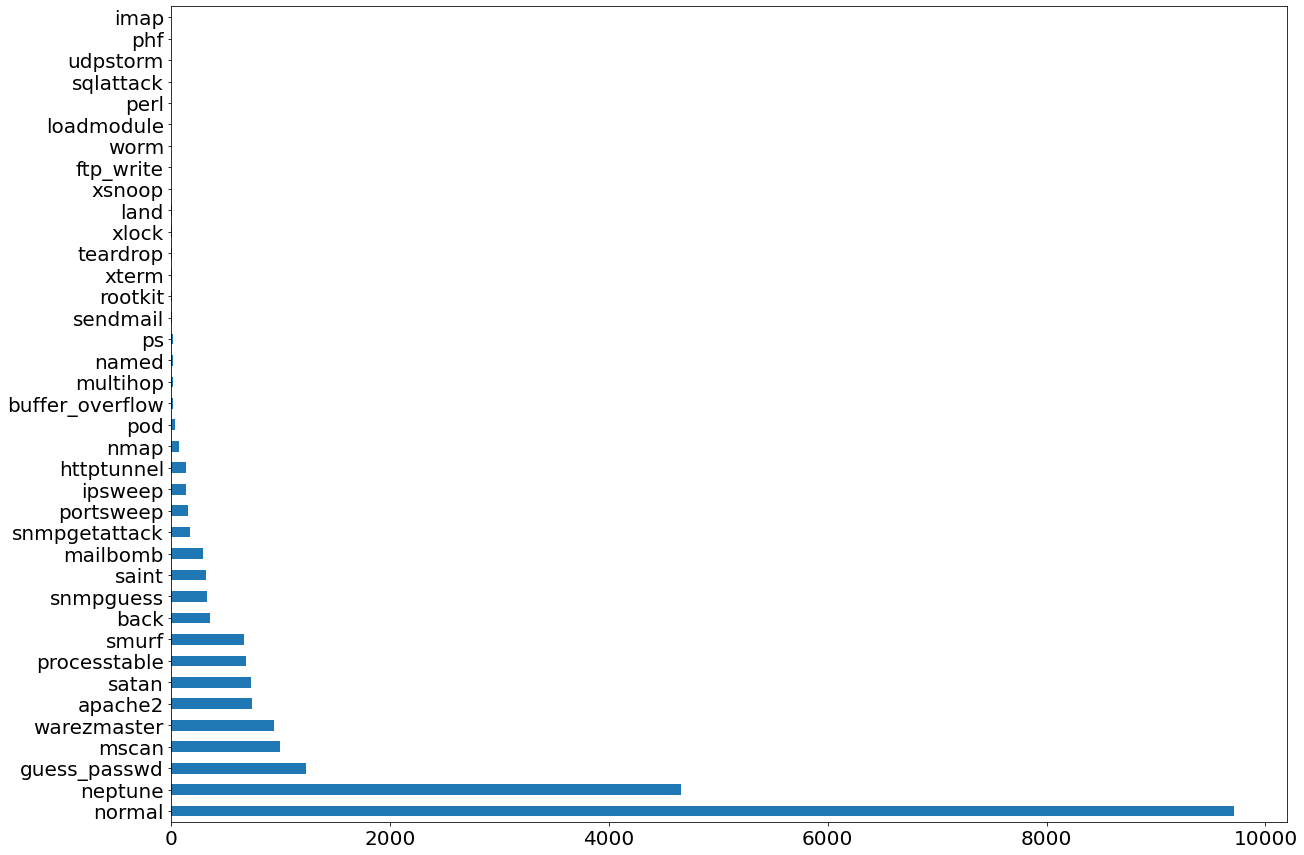

In [8]:
test_attack_types.plot(kind='barh', figsize=(20,15), fontsize=20)

<AxesSubplot:>

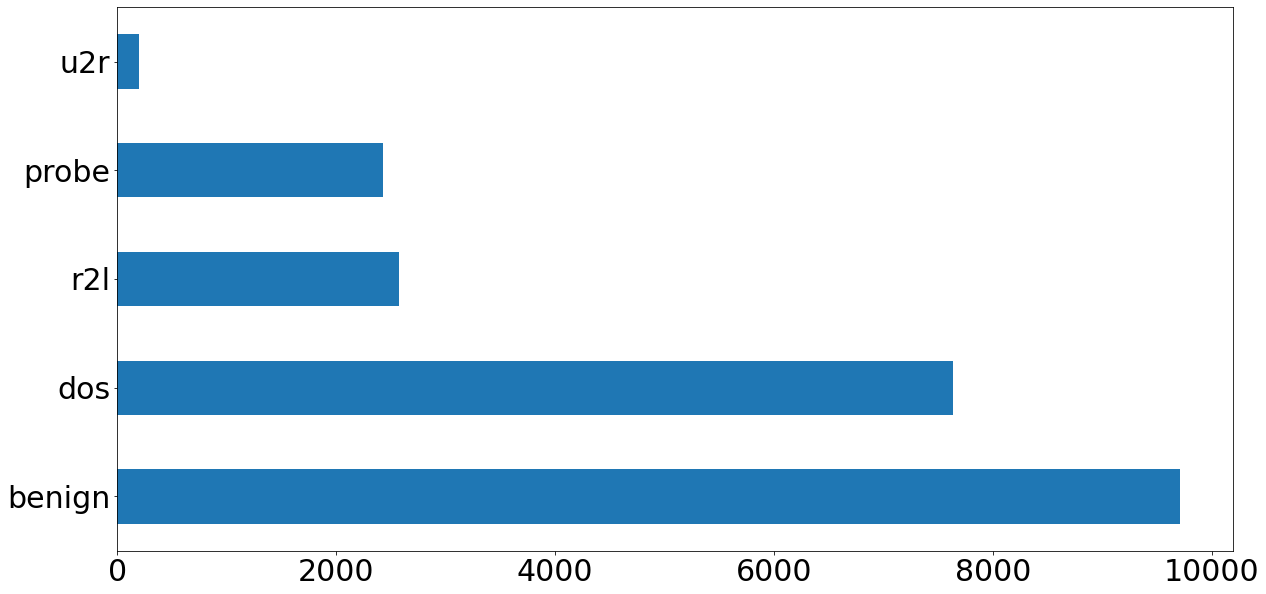

In [9]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

In [10]:
train_df[binary_cols].describe().transpose()
train_df.groupby(['su_attempted']).size()
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

In [11]:
train_df.groupby(['num_outbound_cmds']).size()
train_df.drop('num_outbound_cmds', axis=1, inplace=True)
test_df.drop('num_outbound_cmds', axis=1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

In [12]:
#Data Preparation
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category', 'attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category', 'attack_type'], axis=1)

combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [13]:
train_x.describe()
train_x['duration'].describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64

In [14]:
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    1.259730e+05
mean     2.549477e-17
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [15]:
# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [16]:
# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
dtype: float64

In [17]:
# Experimenting with MaxAbsScaler on the single 'duration' feature
from sklearn.preprocessing import MaxAbsScaler

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [18]:
# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])
train_x[numeric_cols] = standard_scaler.transform(train_x[numeric_cols])
test_x[numeric_cols] = standard_scaler.transform(test_x[numeric_cols])
train_x.describe()

train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

# SECTION 3: Multi class classification
#This is the section where you have to add other algorithms, tune algorithms and visualize to compare and analyze algorithms

In [19]:
import time
from sklearn import metrics

In [20]:
# 5-class classification version
from sklearn.tree import DecisionTreeClassifier

start = time.time()
tree = DecisionTreeClassifier(random_state=17)
tree.fit(train_x, train_Y)
pred_y = tree.predict(test_x)
end = time.time()

In [21]:
def output():
    names = ('benign', 'dos', 'probe', 'r2l', 'u2r')
    conf_matrix = metrics.confusion_matrix(test_Y, pred_y)
    TP = np.diag(conf_matrix)
    FP = conf_matrix.sum(axis=0) - TP
    FN = conf_matrix.sum(axis=1) - TP
    TN = conf_matrix.sum() - (FP + FN + TP)
    FPR = (FP/(FP+TN))
    
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification report:\n", metrics.classification_report(test_Y, pred_y, digits=5))
    for i in range(5):
        print("FPR of ", names[i], " is: {:.5f}" .format(FPR[i]))
    print("Average FPR is : {:.5f}" .format(sum(FPR) / len(FPR)))
    print("\nAccuracy Score: {:.5f}" .format(metrics.accuracy_score(test_Y, pred_y)))
    print("Zero one loss: {:.5f}" .format(metrics.zero_one_loss(test_Y, pred_y)))
    print("Time taken: {:.5f}" .format(end - start), "seconds")

In [22]:
print("Decision Tree Classifier results are shown below.\n")
output()
print("ROC area: ", metrics.roc_auc_score(test_Y, tree.predict_proba(test_x), multi_class="ovr"))

Decision Tree Classifier results are shown below.

Confusion Matrix:
 [[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]

Classification report:
               precision    recall  f1-score   support

      benign    0.66721   0.96437   0.78873      9711
         dos    0.95586   0.78549   0.86234      7636
       probe    0.79026   0.62980   0.70096      2423
         r2l    0.97880   0.10761   0.19391      2574
         u2r    0.78947   0.07500   0.13699       200

    accuracy                        0.76211     22544
   macro avg    0.83632   0.51245   0.53659     22544
weighted avg    0.81487   0.76211   0.73053     22544

FPR of  benign  is: 0.36398
FPR of  dos  is: 0.01858
FPR of  probe  is: 0.02013
FPR of  r2l  is: 0.00030
FPR of  u2r  is: 0.00018
Average FPR is : 0.08063

Accuracy Score: 0.76211
Zero one loss: 0.23789
Time taken: 5.85042 seconds
ROC area:  0.7171628278456702


In [23]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(train_x, train_Y)
pred_y = knn.predict(test_x)
end = time.time()
print("K-Nearest Neighbors classifier results are shown below.")
output()
print("\nROC area: ", metrics.roc_auc_score(test_Y, knn.predict_proba(test_x), multi_class="ovr"))

K-Nearest Neighbors classifier results are shown below.
Confusion Matrix:
 [[9446   54  205    5    1]
 [1630 5924   82    0    0]
 [ 612  179 1632    0    0]
 [2360    2   40  171    1]
 [ 166    0   17    9    8]]

Classification report:
               precision    recall  f1-score   support

      benign    0.66456   0.97271   0.78963      9711
         dos    0.96184   0.77580   0.85886      7636
       probe    0.82591   0.67355   0.74199      2423
         r2l    0.92432   0.06643   0.12396      2574
         u2r    0.80000   0.04000   0.07619       200

    accuracy                        0.76211     22544
   macro avg    0.83533   0.50570   0.51813     22544
weighted avg    0.81346   0.76211   0.72563     22544

FPR of  benign  is: 0.37154
FPR of  dos  is: 0.01576
FPR of  probe  is: 0.01710
FPR of  r2l  is: 0.00070
FPR of  u2r  is: 0.00009
Average FPR is : 0.08104

Accuracy Score: 0.76211
Zero one loss: 0.23789
Time taken: 241.57478 seconds

ROC area:  0.7365336921928327


In [24]:
from sklearn.naive_bayes import GaussianNB
start = time.time()
gnb = GaussianNB()
gnb.fit(train_x, train_Y)
pred_y = gnb.predict(test_x)
end = time.time()
print("Gaussian Naive Bayes classifier results are shown below.")
output()
print("\nROC area: ", metrics.roc_auc_score(test_Y, gnb.predict_proba(test_x), multi_class="ovr"))

Gaussian Naive Bayes classifier results are shown below.
Confusion Matrix:
 [[6756   62   10 2599  284]
 [3400 3162    4 1041   29]
 [1382  345  237  323  136]
 [1113    3    6  933  519]
 [ 115    0    0   22   63]]

Classification report:
               precision    recall  f1-score   support

      benign    0.52922   0.69571   0.60115      9711
         dos    0.88522   0.41409   0.56424      7636
       probe    0.92218   0.09781   0.17687      2423
         r2l    0.18971   0.36247   0.24907      2574
         u2r    0.06111   0.31500   0.10236       200

    accuracy                        0.49463     22544
   macro avg    0.51749   0.37702   0.33873     22544
weighted avg    0.64912   0.49463   0.49842     22544

FPR of  benign  is: 0.46832
FPR of  dos  is: 0.02750
FPR of  probe  is: 0.00099
FPR of  r2l  is: 0.19955
FPR of  u2r  is: 0.04332
Average FPR is : 0.14794

Accuracy Score: 0.49463
Zero one loss: 0.50537
Time taken: 2.59726 seconds

ROC area:  0.7004035165967245


In [25]:
from sklearn.linear_model import LogisticRegression
start = time.time()
clf = LogisticRegression(C=0.75, random_state=17)
clf.fit(train_x, train_Y)
pred_y = clf.predict(test_x)
end = time.time()
print("Logistic Regression classifier results are shown below.")
output()
print("\nROC area: ", metrics.roc_auc_score(test_Y, clf.predict_proba(test_x), multi_class="ovr"))

Logistic Regression classifier results are shown below.
Confusion Matrix:
 [[9000   90  617    2    2]
 [1564 6052   20    0    0]
 [ 489  100 1831    3    0]
 [2479    3    2   90    0]
 [ 183    3    0    5    9]]

Classification report:
               precision    recall  f1-score   support

      benign    0.65622   0.92678   0.76838      9711
         dos    0.96863   0.79256   0.87179      7636
       probe    0.74130   0.75567   0.74842      2423
         r2l    0.90000   0.03497   0.06731      2574
         u2r    0.81818   0.04500   0.08531       200

    accuracy                        0.75328     22544
   macro avg    0.81686   0.51100   0.50824     22544
weighted avg    0.80045   0.75328   0.71516     22544

FPR of  benign  is: 0.36741
FPR of  dos  is: 0.01315
FPR of  probe  is: 0.03176
FPR of  r2l  is: 0.00050
FPR of  u2r  is: 0.00009
Average FPR is : 0.08258

Accuracy Score: 0.75328
Zero one loss: 0.24672
Time taken: 79.78312 seconds

ROC area:  0.8482075422927318


In [26]:
from sklearn.svm import SVC
start = time.time()
svc = SVC(kernel='poly', C=0.5, probability=True)
svc.fit(train_x, train_Y)
pred_y = svc.predict(test_x)
end = time.time()
print("Support Vector Machine classifier results are shown below.")
output()
print("\nROC area: ", metrics.roc_auc_score(test_Y, svc.predict_proba(test_x), multi_class="ovr"))

Support Vector Machine classifier results are shown below.
Confusion Matrix:
 [[9393   58  259    1    0]
 [1928 5677   31    0    0]
 [ 660  169 1594    0    0]
 [2332    0    4  237    1]
 [ 178    1    2    8   11]]

Classification report:
               precision    recall  f1-score   support

      benign    0.64820   0.96725   0.77622      9711
         dos    0.96139   0.74345   0.83849      7636
       probe    0.84339   0.65786   0.73916      2423
         r2l    0.96341   0.09207   0.16809      2574
         u2r    0.91667   0.05500   0.10377       200

    accuracy                        0.75018     22544
   macro avg    0.86661   0.50313   0.52515     22544
weighted avg    0.81363   0.75018   0.71793     22544

FPR of  benign  is: 0.39726
FPR of  dos  is: 0.01529
FPR of  probe  is: 0.01471
FPR of  r2l  is: 0.00045
FPR of  u2r  is: 0.00004
Average FPR is : 0.08555

Accuracy Score: 0.75018
Zero one loss: 0.24982
Time taken: 2831.05316 seconds

ROC area:  0.8655875968704446


In [27]:
# from sklearn.ensemble import RandomForestClassifier
# start = time.time()
# rfc = RandomForestClassifier(random_state=17)
# rfc.fit(train_x, train_Y)
# pred_y = rfc.predict(test_x)
# end = time.time()
# output()
# print("\nROC area: ", metrics.roc_auc_score(test_Y, rfc.predict_proba(test_x), multi_class="ovr"))

In [28]:
from sklearn.neural_network import MLPClassifier
start = time.time()
neural = MLPClassifier(random_state=17, solver='lbfgs')
neural.fit(train_x, train_Y)
pred_y = neural.predict(test_x)
end = time.time()
print("Multi-Layer Perceptron classifier results are shown below.")
output()
print("\nROC area: ", metrics.roc_auc_score(test_Y, neural.predict_proba(test_x), multi_class="ovr"))

Multi-Layer Perceptron classifier results are shown below.
Confusion Matrix:
 [[9435   60  212    1    3]
 [1341 6191  104    0    0]
 [ 657  171 1593    2    0]
 [2161    0   29  377    7]
 [ 175    0    8    9    8]]

Classification report:
               precision    recall  f1-score   support

      benign    0.68523   0.97158   0.80366      9711
         dos    0.96403   0.81076   0.88078      7636
       probe    0.81860   0.65745   0.72923      2423
         r2l    0.96915   0.14646   0.25447      2574
         u2r    0.44444   0.04000   0.07339       200

    accuracy                        0.78087     22544
   macro avg    0.77629   0.52525   0.54831     22544
weighted avg    0.82428   0.78087   0.75260     22544

FPR of  benign  is: 0.33772
FPR of  dos  is: 0.01550
FPR of  probe  is: 0.01754
FPR of  r2l  is: 0.00060
FPR of  u2r  is: 0.00045
Average FPR is : 0.07436

Accuracy Score: 0.78087
Zero one loss: 0.21913
Time taken: 382.33443 seconds

ROC area:  0.8781452230500515


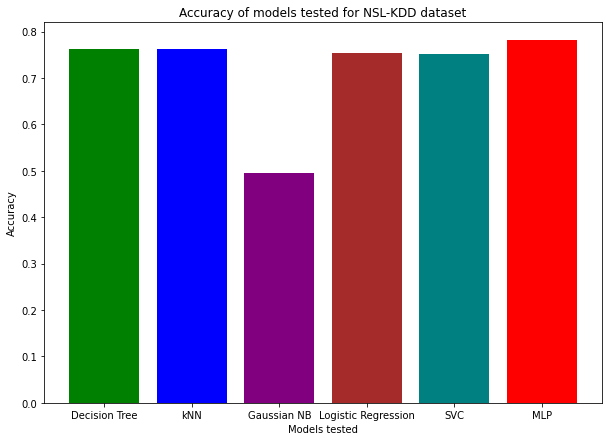

In [29]:
accu_bar_plot = {'Decision Tree':0.76211, 'kNN':0.76211, 'Gaussian NB':0.49463, 'Logistic Regression':0.75328, 'SVC':0.75081, 'MLP':0.78087}
Models = list(accu_bar_plot.keys())
Accuracy = list(accu_bar_plot.values())

fig = plt.figure(figsize = (10, 7))
plt.bar(Models, Accuracy, color=['green', 'blue', 'purple', 'brown', 'teal', 'red'])
plt.xlabel("Models tested")
plt.ylabel("Accuracy")
plt.title("Accuracy of models tested for NSL-KDD dataset")
plt.show()

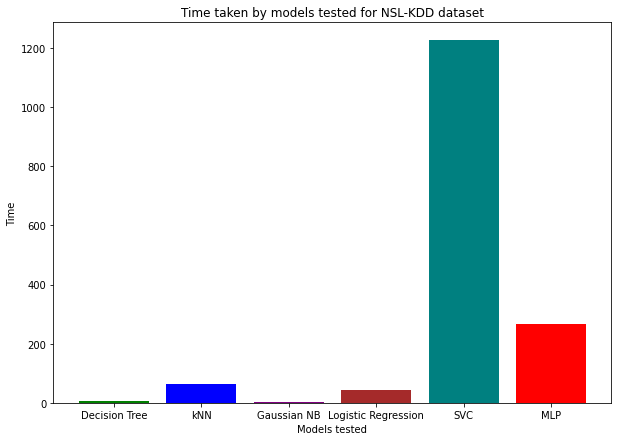

In [31]:
time_bar_plot = {'Decision Tree':5.42, 'kNN':62.58, 'Gaussian NB':2.29, 'Logistic Regression':42.83, 'SVC':1226.1, 'MLP':265.58}
Models = list(time_bar_plot.keys())
Time = list(time_bar_plot.values())

fig = plt.figure(figsize = (10, 7))
plt.bar(Models, Time, color=['green', 'blue', 'purple', 'brown', 'teal', 'red'])
plt.xlabel("Models tested")
plt.ylabel("Time")
plt.title("Time taken by models tested for NSL-KDD dataset")
plt.show()